# Examination 1 (27/06/2023 - 04/07/2023)

---
**Yêu cầu Bài 1**
1. Tách rời đường bao quanh của lọ
2. Tính diện tính phần chữ bên trong lọ (Đơn vị Pixel)

**Yêu cầu Bài 2**


1.   Tìm và vẽ hình chữ nhật bao quanh tất cả con chip (có 8 con chip)
2.   Với mỗi con chip tìm được tìm tất cả các chân của con chip đó
3.   Với mỗi chân của từng con chip hãy tính chiều dài của chúng (lấy theo kích thước smallest rectangle 2 và cho biết góc nghiêng của nó)

4.   So sánh góc nghiêng của mỗi con chip với từng chân của nó (Dựa theo cách tìm smallest rectangle 2)

**Kiến thức nắm được**
1. Chuyến ảnh sang hệ màu xám
2. Biết Nhị phân hóa ảnh (Các phép toán nhị phân hóa trên ảnh)
3. Biết sử dụng các phép toán morphological (Erosion, Dilation, Opening, Closing)
4. Biết sử dụng các phép toán logic (And, Or, Xor, Not)
5. Biết sử dụng hàm Sobel, Canny đề tìm biên cũng như đường bao của đối tượng
6. Tìm contour của đối tượng
7. Biết sử dụng hàm fillUp
8. Select shape theo feature (width, height, area)
9. Biết tách kênh màu của ảnh, biết áp dụng việc cân bằng histogram vào quá trình nhị phân hóa ảnh.
10. Biết cách xây dựng hàm range thresholding
11. Biết cách xây dựng các hàm Morphologigcal tùy theo bài toán (OpeningRectangle, OpeningCircle, ClosingRectangle, ClosingCircle)
12. Biết cách tạo mask như 1 cách giới hạn vùng thao tác trên ảnh.

**Một số hàm để viết chữ và vẽ hình chữ nhật**
1. cv2.putText()
2. cv2.rectangle()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv_imshow

# Ham tao mat na theo struct tuy chon
def OpeningRectangle(region,Width,Height):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (Width, Height))
  regionErosion = cv2.erode(region, kernel,iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  RegionOpening = cv2.dilate(regionErosion, kernel,  borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  return RegionOpening

def ClosingRectangle(region, Width, Height):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (Width, Height))
  regionDilation = cv2.dilate(region, kernel,borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  RegionClosing= cv2.erode(regionDilation, kernel, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  return RegionClosing

def OpeningCircle(region,Radius):
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2 * Radius + 1, 2 * Radius + 1))
  regionErosion = cv2.erode(region, kernel,iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  RegionOpening = cv2.dilate(regionErosion, kernel,  borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  return RegionOpening

def ClosingCircle(region, Radius):
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2 * Radius + 1, 2 * Radius + 1))
  regionDilation = cv2.dilate(region, kernel,borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  RegionClosing= cv2.erode(regionDilation, kernel, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
  return RegionClosing


# Ham chon vung anh co dien tich lon nhat
def SelectShape(image):
  serial_label, label, stats, centre = cv2.connectedComponentsWithStats(image)

  maxArea = max(stats[1:,4])
  area = list(stats[:,4])

  index = area.index(maxArea)

  selectRegion = np.array(label,np.uint8)
  selectRegion[label == index] = 255
  selectRegion[label != index] = 0

  return selectRegion, maxArea


# Ham fillup anh vung kin theo toa do
def fillup(image, start_point, new_color):
  height, width = image.shape
  visited = set()
  stack = [start_point]

  while stack:
    x, y = stack.pop()
    visited.add((x, y))
    image[x, y] = new_color

    neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
    for neighbor in neighbors:
      nx, ny = neighbor
      if 0 <= nx < height and 0 <= ny < width and (nx, ny) not in visited and image[nx, ny] != new_color:
        stack.append((nx, ny))



def FillUp(Region):
    im_floodfill = cv2.copyMakeBorder(Region, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)

    h, w = im_floodfill.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(im_floodfill, mask, (0,0), 255, flags = 4)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:(1 + Region.shape[0]), 1:(1 + Region.shape[1])]

    RegionFillUp = Region | im_floodfill_inv
    return RegionFillUp



def SelectShapeHeightAndUnion(Region, minHeight, maxHeight,isUnion = True):
  numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(Region, 8, cv2.CV_32S)

  h, w = Region.shape

  SelectedRegion = np.zeros((h, w), np.uint8)

  if numLabels <= 1:
      return SelectedRegion, 0

  heights = list(stats[:,3])
  witdths = list(stats[:,2])
  area = list(stats[:,4])
  list_width =[]
  list_height =[]
  list_area =[]
  numObj = 0
  list_object=[]
  for i in range(1, numLabels):
    if heights[i] <= maxHeight and heights[i] >= minHeight:
      ObjectSelected = np.array(labels, dtype=np.uint8)

      ObjectSelected[i == labels] = 255
      ObjectSelected[i != labels] = 0

      list_width.append(witdths[i])
      list_height.append(heights[i])
      list_area.append(area[i])

      if isUnion:
        SelectedRegion = cv2.bitwise_or(ObjectSelected, SelectedRegion)
      else:
        list_object.append(ObjectSelected)
      numObj += 1
  if isUnion:
    return SelectedRegion, numObj
  else:
    return list_object ,numObj

def SelectShapeWidthAndUnion(Region, minWidth, maxWidth):
  numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(Region, 8, cv2.CV_32S)

  h, w = Region.shape

  SelectedRegion = np.zeros((h, w), np.uint8)

  if numLabels <= 1:
      return SelectedRegion, 0

  widths = list(stats[:,2])

  numObj = 0
  for i in range(1, numLabels):
    if widths[i] <= maxWidth and widths[i] >= minWidth:
      ObjectSelected = np.array(labels, dtype=np.uint8)

      ObjectSelected[i == labels] = 255
      ObjectSelected[i != labels] = 0
      SelectedRegion = cv2.bitwise_or(ObjectSelected, SelectedRegion)
      numObj += 1
  return SelectedRegion, numObj

def SelectShapeAreaAndUnion(Region, minArea, maxArea):
  numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(Region, 8, cv2.CV_32S)

  h, w = Region.shape

  SelectedRegion = np.zeros((h, w), np.uint8)

  if numLabels <= 1:
      return SelectedRegion, 0

  areas = list(stats[:,4])

  # top,left,width,heigth, area
  sum_area = 0
  numObj = 0
  for i in range(1, numLabels):
    if areas[i] <= maxArea and areas[i] >= minArea:
      ObjectSelected = np.array(labels, dtype=np.uint8)

      ObjectSelected[i == labels] = 255
      ObjectSelected[i != labels] = 0
      SelectedRegion = cv2.bitwise_or(ObjectSelected, SelectedRegion)
      numObj += 1
      sum_area += areas[i]
  return SelectedRegion, numObj, sum_area

# EXAM 1


## Load Ảnh -> Chuyển sang hệ màu GRAY

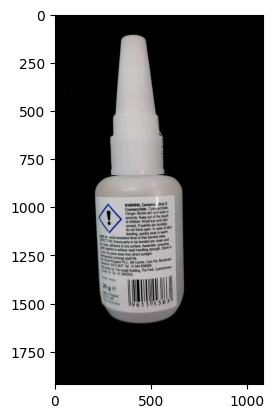

In [2]:
bottle = cv2.imread("images/1.jpg")
plt.imshow(bottle)

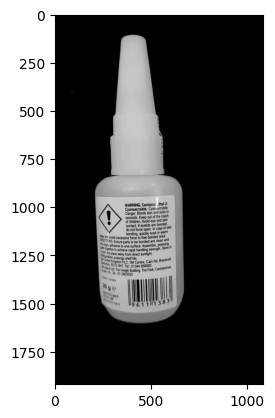

In [3]:
bottle_gr = cv2.cvtColor(bottle,cv2.COLOR_BGR2GRAY)
plt.imshow(bottle_gr, cmap = 'gray')

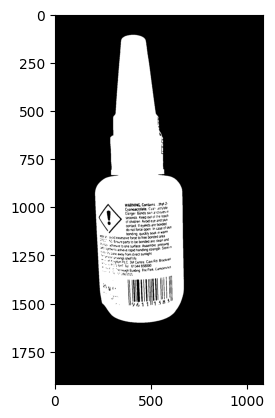

In [4]:
_,bottle_binary = cv2.threshold(bottle_gr,90,255,cv2.THRESH_BINARY)
plt.imshow(bottle_binary, cmap='gray')

## Detect Edge (Canny, Sobel)

In [5]:
bottle_gau = cv2.GaussianBlur(bottle_gr,(5,5),cv2.BORDER_DEFAULT)

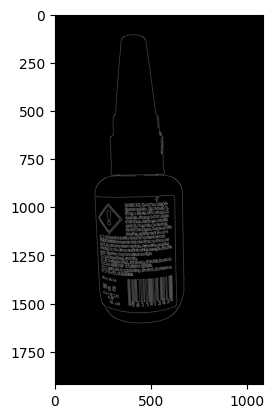

In [6]:
bottle_canny = cv2.Canny(bottle_gau,10,100)
#plt.imshow(bottle_canny, cmap ='gray')
plt.imshow(bottle_canny, cmap='gray')

## FillUP

In [7]:
bottle_canny_copy = bottle_canny.copy()
bottle_canny_closing = ClosingRectangle(bottle_canny_copy,5,5)
#-----------------------------
bottle_canny_closing_copy = bottle_canny_closing.copy()
# FillUp lần 1
fillup(bottle_canny_closing_copy,(0,0),255)

In [8]:
bottle_canny_closing = bottle_canny_closing.astype(np.uint8)

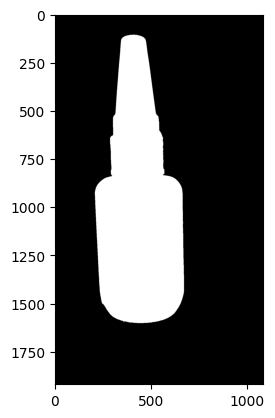

In [9]:
img_area = cv2.bitwise_not(bottle_canny_closing_copy)
img_area_fill  = bottle_canny_closing | img_area
plt.imshow(img_area_fill, cmap='gray')

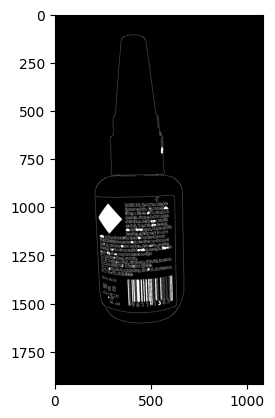

In [11]:
fillUP = FillUp(bottle_canny)
plt.imshow(fillUP, cmap="gray")

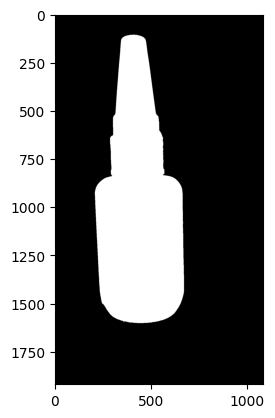

In [12]:
fillUpRegion = img_area | bottle_canny_closing
plt.imshow(fillUpRegion, cmap = 'gray')

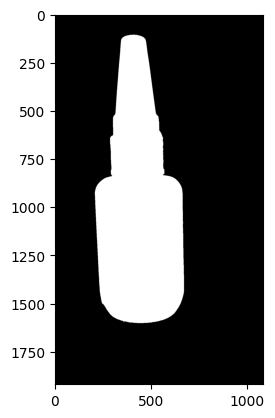

In [13]:
fillUpRegionClosing = ClosingRectangle(fillUpRegion,1,1)
plt.imshow(fillUpRegionClosing, cmap='gray')

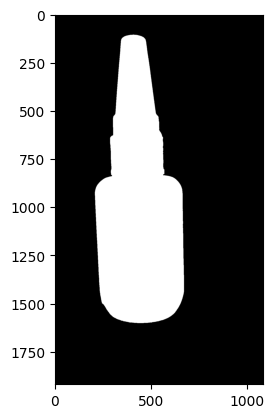

In [14]:
# FillUp lần 2
fillUpRegionClosing_Copy   = fillUpRegionClosing.copy()

fillup(fillUpRegionClosing_Copy,(0,0),255)
img_area = cv2.bitwise_not(fillUpRegionClosing_Copy)
fillUpRegion_2 = cv2.bitwise_or(img_area ,fillUpRegionClosing)

# Opening Rectangle
fillUpRegion_2_Opening = OpeningRectangle(fillUpRegion_2,5,3)
plt.imshow(fillUpRegion_2_Opening,cmap='gray')

## Select Shape (Max Area)

max Area: 475377


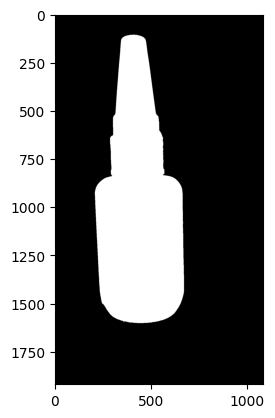

In [15]:
maxRegion, area = SelectShape(fillUpRegionClosing)
print(f'max Area: {area}')
plt.imshow(maxRegion, cmap='gray')

## Erosion -> Edge =  Diff (Box, Erosion(Box))

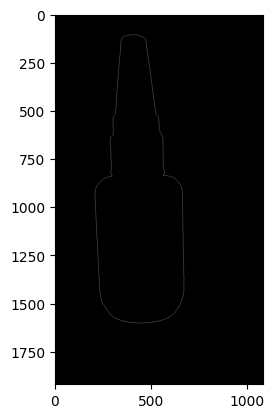

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosionRegion = cv2.erode(maxRegion,kernel,iterations = 1)

diff = cv2.bitwise_xor(maxRegion,erosionRegion)
plt.imshow(diff, cmap='gray')

## Tinh dien tich phan chu

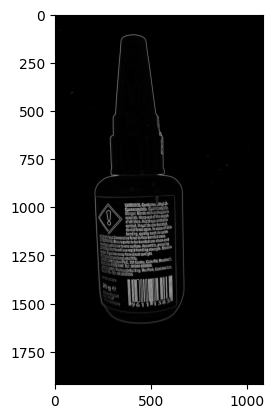

In [17]:
#gau_img = cv2.GaussianBlur(bottle_gr,(3,3),cv2.BORDER_DEFAULT)

equalhist = cv2.equalizeHist(bottle_gr)

_,bottle_binary1 = cv2.threshold(bottle_gr,175,255,cv2.THRESH_BINARY)
sobel1 = cv2.Sobel(bottle_gr,cv2.CV_64F,1,0,3)
sobel2 = cv2.Sobel(bottle_gr,cv2.CV_64F,0,1,3)
sobel = np.sqrt(sobel1**2 + sobel2**2)
plt.imshow(sobel, cmap='gray')
#cv_imshow(canny1)

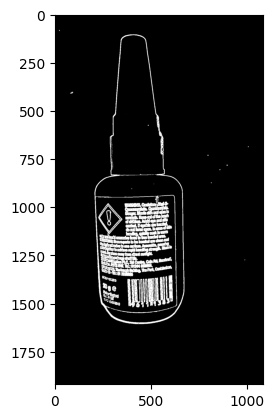

In [18]:
_,bottle_thresh1 = cv2.threshold(sobel,50,255,cv2.THRESH_BINARY)
plt.imshow(bottle_thresh1, cmap='gray')

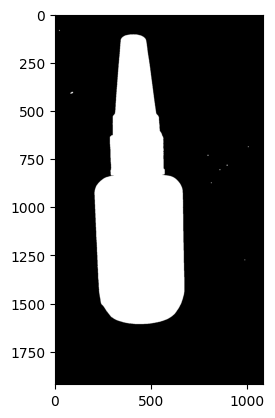

In [19]:
bottle_thresh1 = bottle_thresh1.astype(np.uint8)
fil = FillUp(bottle_thresh1)
plt.imshow(fil,cmap ='gray')

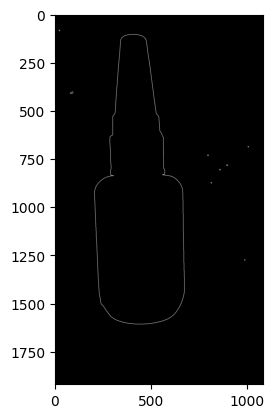

In [20]:
Sobel_x = cv2.Sobel(fil,cv2.CV_64F,1,0,3)
Sobel_y = cv2.Sobel(fil,cv2.CV_64F,0,1,3)
Sobel_xy = abs(np.sqrt(Sobel_x**2 + Sobel_y**2))
plt.imshow(Sobel_xy, cmap='gray')

## Get edge

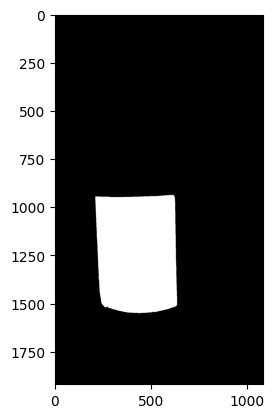

In [21]:
filmax,_ = SelectShape(fil)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosionRegion = cv2.erode(filmax,kernel,iterations = 3)

diff2 = cv2.bitwise_xor(filmax,erosionRegion)

diff3 = cv2.bitwise_xor(bottle_thresh1,diff2)
label = FillUp(diff3)
label_opening = OpeningRectangle(label,9,1)
label_max,_ = SelectShape(label_opening)

plt.imshow(label_max, cmap='gray')

Tong area: 103254


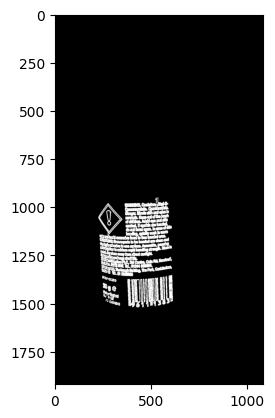

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosionRegion = cv2.erode(label_max,kernel,iterations = 9)

letter = cv2.bitwise_and(bottle_thresh1,erosionRegion)
letter_area,_ , sum_area= SelectShapeAreaAndUnion(letter,100,90000)
print(f'Tong area: {sum_area}')
plt.imshow(letter_area, cmap='gray')

In [23]:
print(Sobel_xy.shape)
print(bottle_thresh1.shape)

(1920, 1080)
(1920, 1080)


In [24]:
_,thresh_sb = cv2.threshold(Sobel_xy,140,255,cv2.THRESH_BINARY)

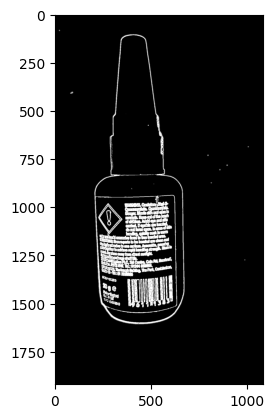

In [25]:
bottle_thresh1 = bottle_thresh1.astype(np.uint8)
Sobel_xy = Sobel_xy.astype(np.uint8)
dif = cv2.bitwise_xor(Sobel_xy, bottle_thresh1)
plt.imshow(dif, cmap='gray')

# EXAM 2


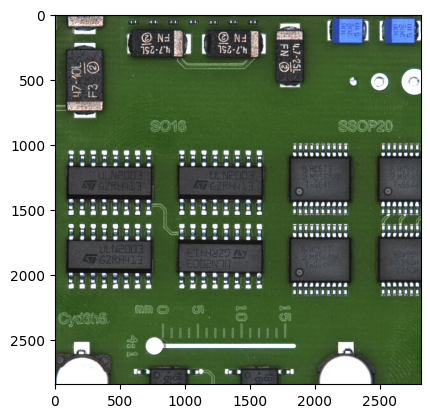

In [30]:
board = cv2.imread("images/BOARD1.jpg")
plt.imshow(board)

# Tim duong bao quanh chip

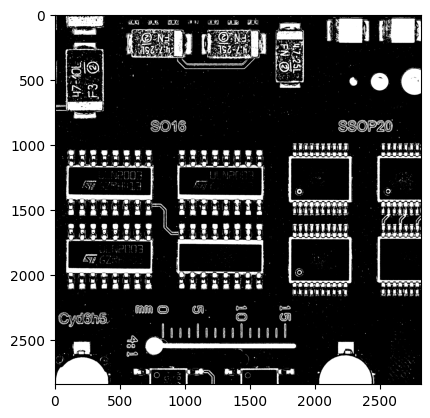

In [31]:
board_gr1 = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
def threshold_range(img_gr,thresh1, thresh2):
  _,threshold1 =cv2.threshold(img_gr,thresh1,255,cv2.THRESH_BINARY_INV)
  _,threshold2 =cv2.threshold(img_gr,thresh2,255,cv2.THRESH_BINARY_INV)

  return cv2.bitwise_xor(threshold1,threshold2)

board1 = threshold_range(board_gr1, 40,100)
board1 = cv2.bitwise_not(board1)
plt.imshow(board1, cmap = 'gray')

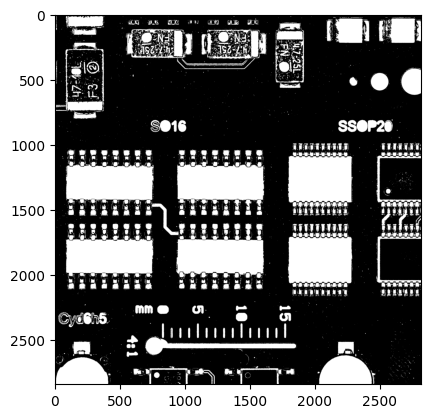

In [32]:
board_fill = FillUp(board1)
plt.imshow(board_fill, cmap='gray')

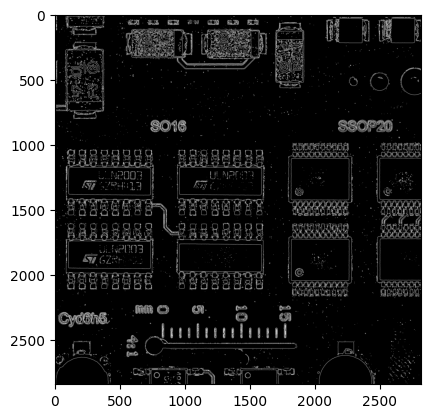

In [33]:
sb_x = abs(cv2.Sobel(board1,cv2.CV_64F,1,0,3))
sb_y = abs(cv2.Sobel(board1,cv2.CV_64F,0,1,3))
sb_xy = np.sqrt(sb_x**2 + sb_y**2)
plt.imshow(sb_xy, cmap = 'gray')

In [34]:
height, wide = sb_xy.shape
zeros = np.zeros_like(sb_xy)

offset = 530

top_left = (int(0),int(height/2 - offset+50))
bottom_right = (int(wide),int(height/2 + offset+270))
ROI1 = cv2.rectangle(zeros,bottom_right,top_left,(255),-1)

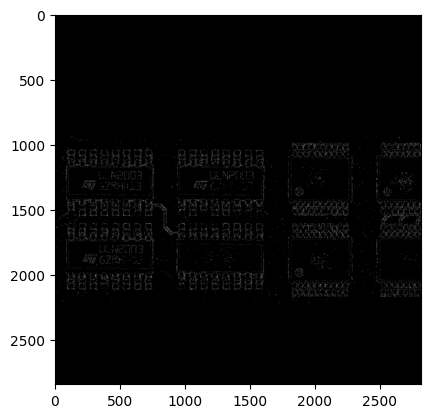

In [35]:
RG = cv2.bitwise_and(ROI1, sb_xy)
plt.imshow(RG, cmap = 'gray')

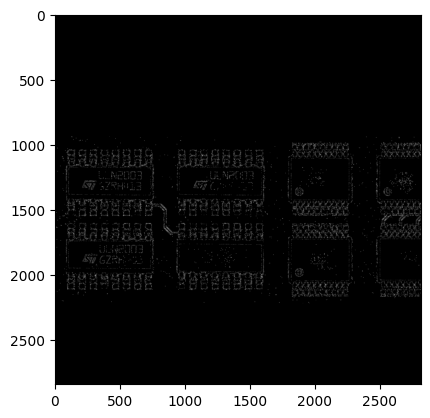

In [36]:
_,THR = cv2.threshold(RG,150,255,cv2.THRESH_BINARY)
plt.imshow(THR,cmap = 'gray')

In [38]:
FILL = FillUp(THR)
plt.imshow(FILL, cmap = 'gray')

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\floodfill.cpp:586: error: (-210:Unsupported format or combination of formats)  in function 'cv::floodFill'


# Tim chan cua moi chip

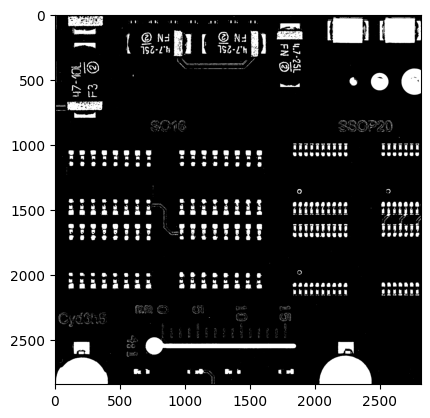

In [39]:
board_b, board_g, board_r = cv2.split(board)
_,thresh_board = cv2.threshold(board_r,120,255,cv2.THRESH_BINARY)
plt.imshow(thresh_board, cmap ='gray')

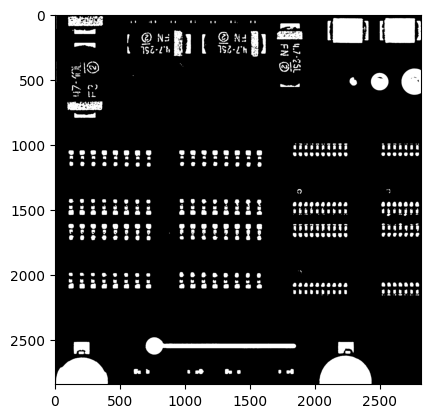

In [40]:
opening1 = OpeningCircle(thresh_board,3)
plt.imshow(opening1, cmap='gray')

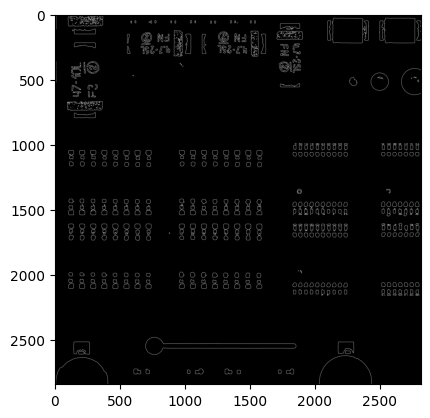

In [41]:
sobel_x = abs(cv2.Sobel(opening1,cv2.CV_64F,1,0,3))
sobel_y = abs(cv2.Sobel(opening1,cv2.CV_64F,0,1,3))
sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
plt.imshow(sobel_xy, cmap = 'gray')

In [42]:
print(sobel_xy.shape)

(2844, 2816)


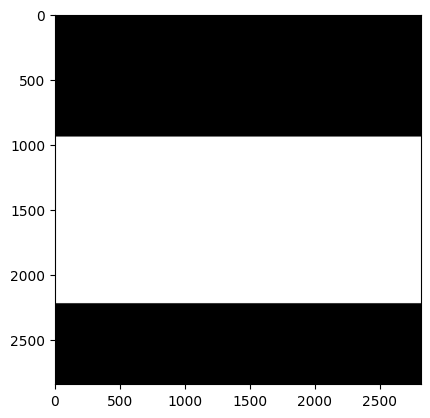

In [43]:
height, wide = sobel_xy.shape
zeros = np.zeros_like(sobel_xy)

offset = 530

top_left = (int(0),int(height/2 - offset+50))
bottom_right = (int(wide),int(height/2 + offset+270))
ROI = cv2.rectangle(zeros,bottom_right,top_left,(255),-1)
plt.imshow(ROI, cmap = 'gray')

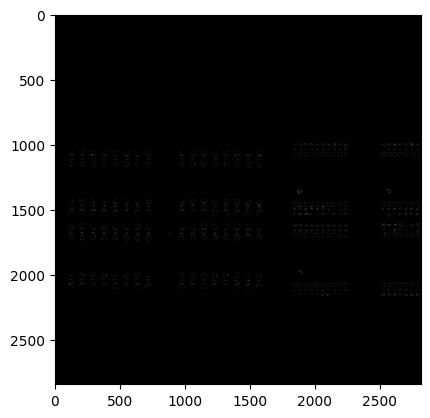

In [44]:
work_region = cv2.bitwise_and(ROI,sobel_xy)
plt.imshow(work_region, cmap = 'gray')

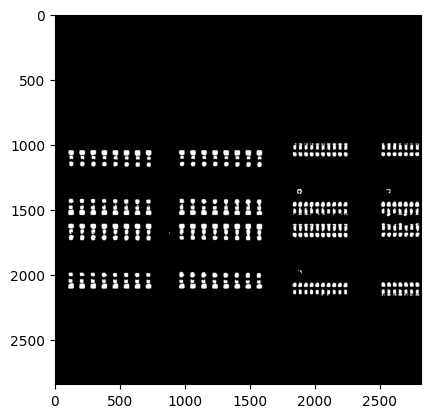

In [45]:
work_region = work_region.astype(np.uint8)
fill1 = FillUp(work_region)
plt.imshow(fill1, cmap = 'gray')

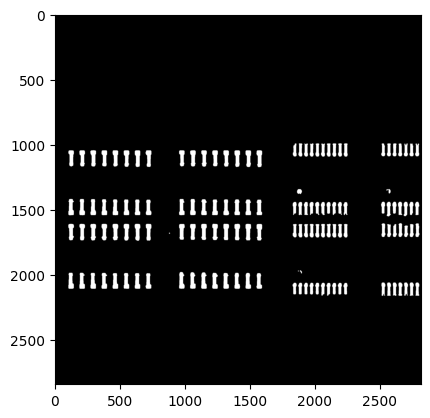

In [46]:
closing1 = ClosingRectangle(fill1,5,30)
plt.imshow(closing1, cmap = 'gray')

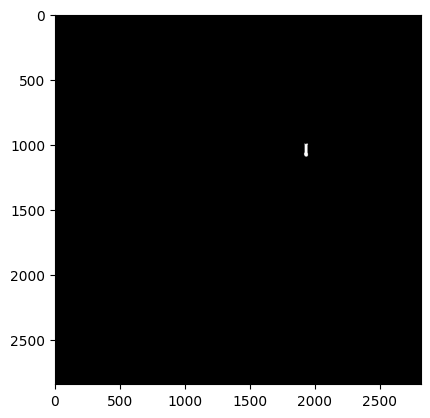

In [47]:
serial_region,num,sum_area = SelectShapeAreaAndUnion(closing1,50,10000)
regions, num = SelectShapeHeightAndUnion(serial_region,50,10000,False)
plt.imshow(regions[2], cmap = 'gray')

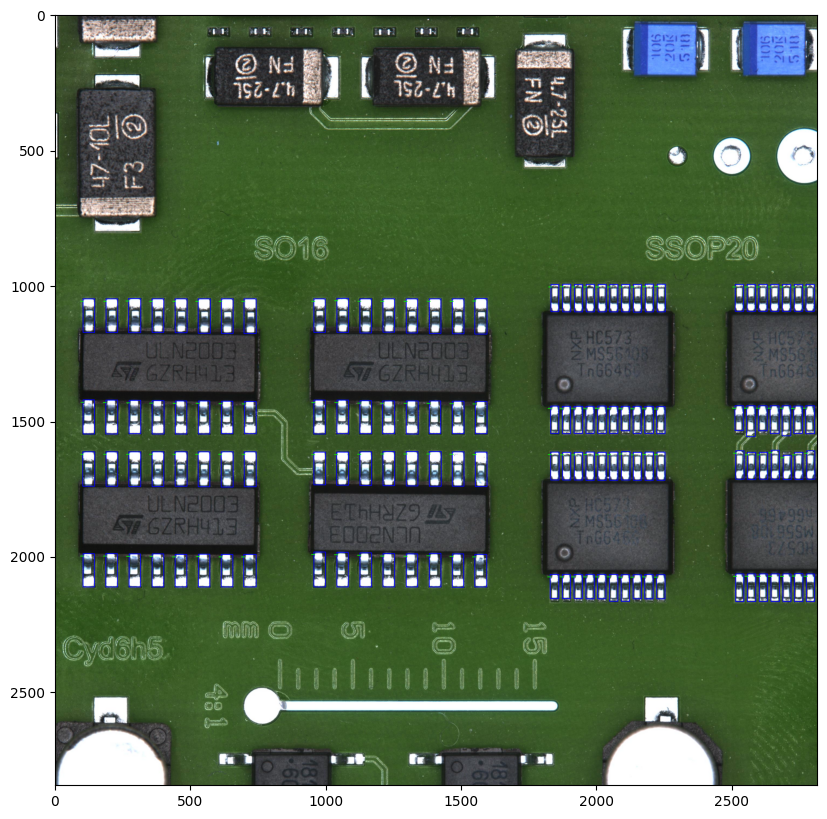

In [49]:
for region in regions:

  x, y, wide,height = cv2.boundingRect(region)
  board = cv2.rectangle(board,(x,y),(x+wide, y+height),(0,0,255), 2)
  #region= cv2.putText(region, 'helo',(0,0),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2,cv2.LINE_AA)
  cv2.putText(board, str(x*y), (x-10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (0,255,0), 1)

plt.figure(figsize=(20,10))
plt.imshow(board)

In [ ]:
draw = cv2.putText(board, 'helo',(0,0),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2,cv2.LINE_AA)
plt.imshow(draw, cmap='gray')

In [50]:
# zip in python
list_a = [1,2,3]
list_b = [4,5,6]
list_c = [7,8,9]
for a, b,c in zip(list_a,list_b,list_c):
  print(f'a:{a} - b:{b} - c:{c}')

a:1 - b:4 - c:7
a:2 - b:5 - c:8
a:3 - b:6 - c:9


[[2133. 2067.]
 [2163. 2067.]
 [2163. 2155.]
 [2133. 2155.]]


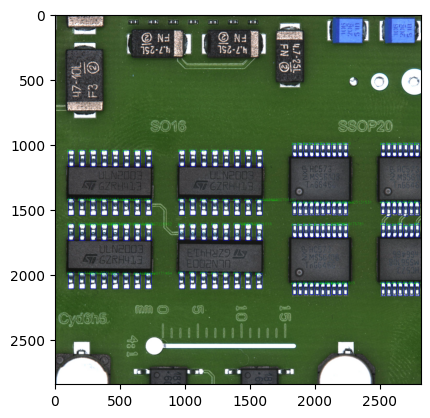

In [52]:
board_copy  = board.copy()
contours, _ = cv2.findContours(closing1,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


rect = cv2.minAreaRect(contours[1])
box = cv2.boxPoints(rect)
print(box)

for cnt,region in zip(contours,regions):
  rect = cv2.minAreaRect(cnt)

  ((center_x, center_y), (dim_x, dim_y), angle) = rect

  # Draw the boundingBox
  x, y, wide,height = cv2.boundingRect(region)
  board_copy = cv2.rectangle(board_copy,(x,y),(x+wide, y+height),(0,0,255), 2)
  cv2.putText(board_copy, str(angle), (x-10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

  # Draw the angle
  cv2.putText(board_copy, str(angle), (x-10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 1)

plt.imshow(board_copy, cmap='gray')

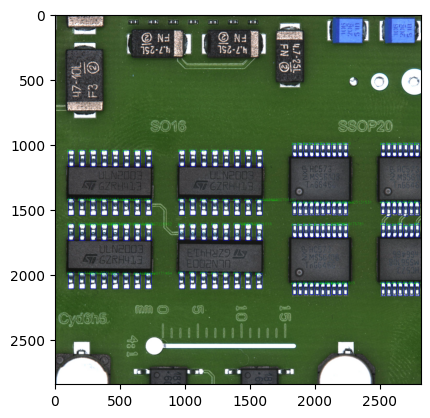

In [53]:
plt.imshow(board_copy)

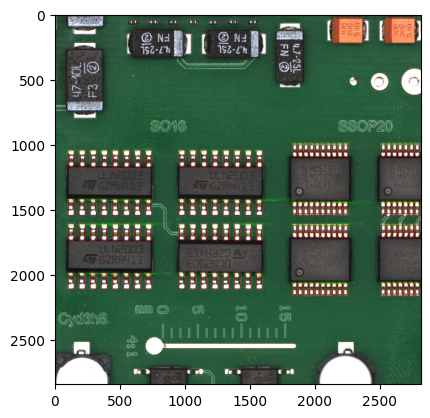

In [54]:
board_copy_rgb = cv2.cvtColor(board_copy,cv2.COLOR_BGR2RGB)
plt.imshow(board_copy_rgb)

# Located Chip

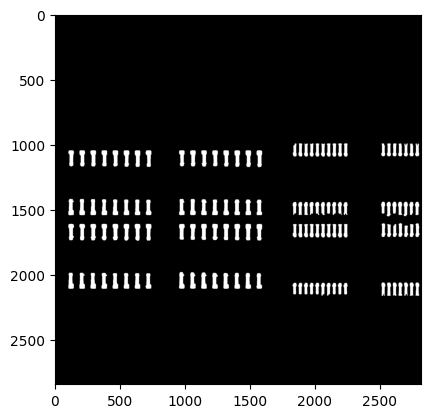

In [55]:
chip_lead, num = SelectShapeHeightAndUnion(serial_region,50,10000,True)
plt.imshow(chip_lead, cmap = 'gray')

## Find chip body

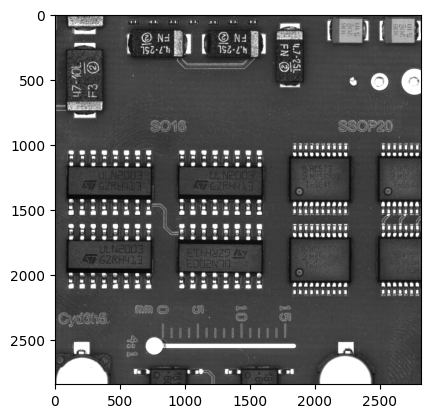

In [56]:
plt.imshow(board_gr1, cmap='gray')

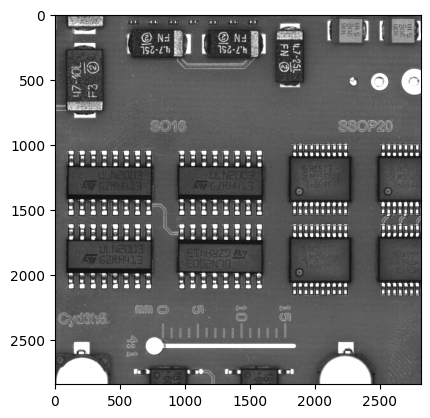

In [58]:
b,g,r =cv2.split(board)
plt.imshow(g, cmap='gray')

<class 'numpy.ndarray'>


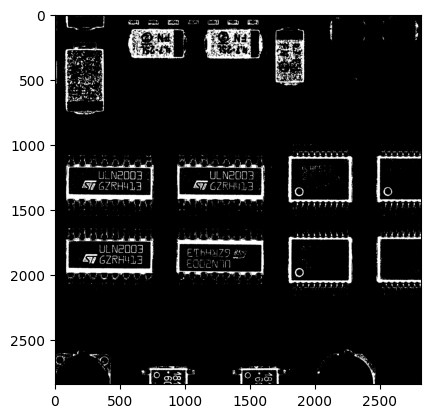

In [59]:
body_threshold =  threshold_range(g, 0,50)
plt.imshow(body_threshold,cmap ='gray')
print(type(body_threshold))

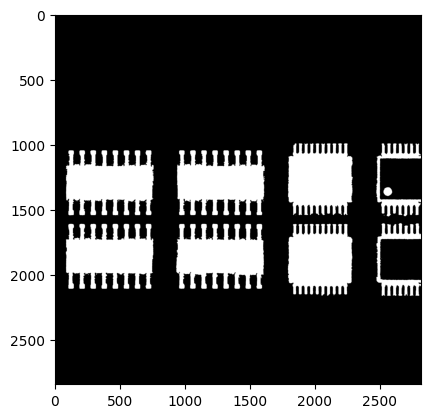

In [60]:
# body_threshold_ROI  = cv2.bitwise_and(ROI,body_threshold)
body_threshold_fill = FillUp(body_threshold)
body_threshold_opening = OpeningRectangle(body_threshold_fill,5,1)

chip_location = cv2.bitwise_or(body_threshold_opening,chip_lead)
chip_location = ClosingCircle(chip_location,3)
chip_location_fill = FillUp(chip_location)
# casting type  (Ép kiểu dữ liệu)
chip_location_fill = chip_location_fill.astype(np.uint8)
ROI = ROI.astype(np.uint8)

chip_location_final  = cv2.bitwise_and(ROI,chip_location_fill)
plt.imshow(chip_location_final, cmap='gray')

In [61]:
chip_located,_ = SelectShapeHeightAndUnion(chip_location_final,100,999999,False)
print(f'Num chip: {len(chip_located)}')

Num chip: 8


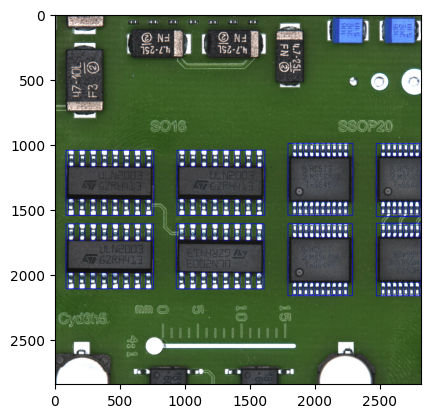

In [62]:
board_copy = board.copy()
for chip in chip_located:
  x, y, wide,height = cv2.boundingRect(chip)
  board_copy = cv2.rectangle(board_copy,(x,y),(x+wide, y+height),(0,0,255), 4)

plt.imshow(board_copy, cmap='gray')